EAE3709 Aplicaciones de Machine Learning en Economía <br>
Primer Semestre 2024

Instituto de Economía<br>
Pontificia Universidad Católica de Chile
# Proyecto Final: Determinantes de las Expectativas de Inflación: Un Enfoque de Machine Learning
- Autores:
    - Javier Navarrete Twyman  [<javier.navarrete@uc.cl>]
    - Pedro Skorin  [ppskorin@uc.cl]
    - Kiran Sargent  [kiran.sargent@uc.cl]
    
- Fecha: 01/07/2024
__________________________________________________________

## Descripción del proyecto
Los Bancos Centrales modernos utilizan cada vez más información de las expectativas de los agentes para la formulación de políticas monetarias. Conocer cómo los agentes forman sus expectativas y disponer de esta información para una mayor parte de la población es relevante para este tipo de institución, que invierte cada vez más en investigaciones con las empresas y la población. En este proyecto, usamos los modelos de Random Forest, XGBoost y Multi-layer Perceptron para predecir la expectativa de inflación a nivel individual con características demográficas y socioeconomicas de los agentes.

La pregunta de investigación que guía este trabajo es: ¿Qué características son más importantes en la predicción de las expectativas de inflación? Para abordar esta pregunta, utilizamos datos provenientes de la encuesta de expectativas de inflación de la FED de Nueva York. Esta encuesta proporciona una amplia gama de información demográfica y socioeconómica de los individuos, como edad, género, estado de empleo, ingresos, estado civil, estado de residencia, entre otros. Estas características se emplean como atributos en modelos de inteligencia artificial para predecir las expectativas de inflación.

Encontramos que el modelo de Random Forest tiene el mejor rendimiento en las predicciones de las expectativas. Además, encontramos que variables socieconomicas, como ingresos, ubicación y educación, ayudan más a explicar las expectativas que variables demográficas como genero o grupo étnico.

## Contenido
1. [Pre-procesamiento](#seccion1)
2. [Análisis Exploratorio de Datos (EDA](#seccion2)
3. [Feature Engineering](#seccion3)
4. [Entrenamiento](#seccion4)
5. [Evaluación](#seccion5)
__________________________________________________________

## 1. Pre-procesamiento <a name="seccion1"></a>

Como hicimos al largo de todo el semestre, comenzamos por importar todas las librerias que vamos a usar en el ejercício.

In [ ]:
# librerias clasicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# otras
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import warnings

Después importamos desde un drive particular la base de datos de las expectativas de inflación. El origen de la base de datos es la FED de Nueva York. En este caso, estamos observando solamente los meses de junio, julio y agosto de 2013.

In [ ]:
# importamos los datos del drive
codigo = '19agMPjwolX8IRPqotbuDkZ1JqXrrGsXq'
link = 'https://drive.google.com/uc?id='
df = pd.read_csv(link + codigo)

Antes de comenzar con el análisis exploratorio de datos, tenemos que hacer una transformación. El objetivo final es mantener únicamente los datos de agosto de 2013, pero algunas columnas para ese mes están vacías. El origen de los datos es una encuesta y algunas preguntas fueron realizadas solo la primera vez que el individuo respondió la encuesta. Por ejemplo, preguntan el género y el grupo étnico del individuo la primera vez. En los meses siguientes, esas respuestas están vacías. Para tener la respuesta en agosto de 2013, agrupamos los datos por persona (columna 'userid') y tomamos el promedio. Con eso, rellenamos todas las columnas vacías con sus valores iniciales (básicamente, el promedio de un solo valor).

Para llevar a cabo este procedimiento en Python, creamos una función llamada 'fill_na_mean' y la aplicamos al vector de preguntas que son realizadas únicamente una vez en la encuesta.

In [ ]:
# funcion que reemplaza missings por promedio del grupo
def fill_na_mean(group):
    return group.fillna(group.mean())

# computamos el promedio por pregunta
column_vector = ['Q32', 'Q33', 'Q34', 'Q35_1', 'Q35_2', 'Q35_3', 'Q35_4', 'Q35_5', 'Q35_6', 'Q36', 'Q38', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6', 'Q10_7', 'Q10_8', 'Q10_9', 'Q10_10', 'Q47']

for i in column_vector:
  means = df.groupby('userid')[i].mean()
  df[i] = df.apply(lambda row: row[i] if not pd.isna(row[i]) else means[row['userid']], axis=1)

Ahora filtramos los datos solo para los datos de agosto de 2013. Además, creamos una nueva variable llamada 'expec', que divide los datos en dos grupos basados en la pregunta 8 de la encuesta. La pregunta 8 trata sobre la expectativa de inflación de los próximos 12 meses. La variable 'expec' es binaria y corresponde a los grupos de inflación baja (menos del 4% de expectativa) e inflación alta (4% o más de expectativa).

In [ ]:
# filrtamos solamente para agosto de 2013
filtered_df = df[df['date'] == 201308].copy()

# creamos la variable categorica de inflacion alta y baja
filtered_df['expec'] = filtered_df['Q8v2part2'].apply(lambda x: 0 if x < 4 else 1)

Con el código a continuación, mostramos un vistazo a las primeras 5 observaciones de los datos. Cada observación corresponde a la respuesta de un individuo en agosto de 2013. Las columnas importantes comienzan en Q8v2: esto representa la pregunta 8 de la encuesta. La Q9 representa la pregunta 9 y así sucesivamente. Hay más columnas en la base de datos (que representan resúmenes de información de preguntas), pero nos interesa solamente las columnas con las respuestas originales.

In [ ]:
filtered_df.head()

,date,userid,repeated,tenure,Q8v2,Q8v2part2,Q9_cent25,Q9_cent50,Q9_cent75,Q9_var,...,DHH2_4,DHH2_5,survey_date,_AGE_CAT,_NUM_CAT,_REGION_CAT,_COMMUTING_ZONE,_EDU_CAT,_HH_INC_CAT,expec
2450,201308,70000238,2,8,1.0,80.0,3.0,3.0,4.0,0.0,...,NaN,NaN,8/10/2013,Over 60,Low,West,323,Some College,Under 50k,1
2451,201308,70000239,2,9,1.0,20.0,12.0,15.0,17.0,10.0,...,NaN,NaN,8/11/2013,Over 60,Low,West,323,College,Under 50k,1
2452,201308,70000294,2,7,1.0,5.0,3.0,3.0,4.0,0.0,...,NaN,NaN,8/1/2013,Under 40,Low,West,423,Some College,Under 50k,1
2453,201308,70000312,2,9,1.0,5.0,2.0,4.0,6.0,6.0,...,NaN,NaN,8/2/2013,40 to 60,High,West,93,College,Over 100k,1
2454,201308,70000327,2,9,1.0,10.0,1.0,4.0,8.0,23.0,...,NaN,NaN,8/1/2013,40 to 60,Low,West,323,Some College,Under 50k,1


En particular, nos va a interesar las columnas dentro del siguiente vector:

['Q8v2part2', 'expec', 'Q32', 'Q33', 'Q34', 'Q35_1', 'Q35_2', 'Q35_3', 'Q35_4', 'Q35_5', 'Q35_6', 'Q36', 'Q38', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6', 'Q10_7', 'Q10_8', 'Q10_9', 'Q10_10', '_STATE', 'Q47']


Las columasn representa lo siguiente:

Q8v2part2 = expectativa de inflación en los proximos 12 meses - numerico

expect = dummy de inflación alta o inflación baja - categorico

Q32 = genero - categorico

Q34 = dummy de latino - categorico

Q35 = grupo etnico - categorico

Q36 = educación - categorico

Q38 = estado civil - categorico

Q10 = estado de empleo - categorico

_STATE = estado de residencia - categorico

Q47 = ingreso - categorico

In [ ]:
# muestra de la base de datos
filtered_df[['Q8v2part2', 'expec', 'Q32', 'Q33', 'Q34', 'Q35_1', 'Q35_2', 'Q35_3', 'Q35_4', 'Q35_5', 'Q35_6', 'Q36', 'Q38', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6', 'Q10_7', 'Q10_8', 'Q10_9', 'Q10_10', '_STATE', 'Q47']].head()

,Q8v2part2,expec,Q32,Q33,Q34,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,...,Q10_3,Q10_4,Q10_5,Q10_6,Q10_7,Q10_8,Q10_9,Q10_10,_STATE,Q47
2450,80.0,1,74.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,CA,5.0
2451,20.0,1,67.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,CA,4.0
2452,5.0,1,33.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,CO,4.0
2453,5.0,1,50.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,CA,11.0
2454,10.0,1,58.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,CA,3.0


Para saber más, podemos usar el comando .info() de Python. La base final tiene 1769 observaciones, la gran mayoría son datos no nulos. Como forma de lidiar con los valores faltantes, los eliminamos de los datos (ya que componen una proporción muy pequeña del total). Haremos un estudio de outliers en la próxima sección.

In [ ]:
# informaciones generales de variables relevantes
filtered_df[['Q8v2part2', 'expec', 'Q32', 'Q33', 'Q34', 'Q35_1', 'Q35_2', 'Q35_3', 'Q35_4', 'Q35_5', 'Q35_6', 'Q36', 'Q38', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6', 'Q10_7', 'Q10_8', 'Q10_9', 'Q10_10', '_STATE', 'Q47']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1769 entries, 2450 to 4218
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Q8v2part2  1758 non-null   float64
 1   expec      1769 non-null   int64  
 2   Q32        1763 non-null   float64
 3   Q33        1768 non-null   float64
 4   Q34        1768 non-null   float64
 5   Q35_1      1769 non-null   float64
 6   Q35_2      1769 non-null   float64
 7   Q35_3      1769 non-null   float64
 8   Q35_4      1769 non-null   float64
 9   Q35_5      1769 non-null   float64
 10  Q35_6      1769 non-null   float64
 11  Q36        1768 non-null   float64
 12  Q38        1768 non-null   float64
 13  Q10_1      1769 non-null   int64  
 14  Q10_2      1769 non-null   int64  
 15  Q10_3      1769 non-null   int64  
 16  Q10_4      1769 non-null   int64  
 17  Q10_5      1769 non-null   int64  
 18  Q10_6      1769 non-null   int64  
 19  Q10_7      1769 non-null   int64  
 20  Q10_8     

## 2. Análisis Exploratorio de Datos <a name="seccion2"></a>

Primero comenzamos analizando las variables dependientes. La primera variable dependiente es directamente la respuesta a la pregunta de cuál será la inflación en los próximos 12 meses. Esa variable tiene nombre Q8v2part2. A continuación presentamos algunos estadísticos de ella. Se puede notar una mediana igual a 4, un mínimo de -80 y un máximo de 100.

In [ ]:
# estadisticos de variable dependiente
filtered_df['Q8v2part2'].describe()

count    1758.000000
mean        6.853242
std        12.859163
min       -80.000000
25%         2.000000
50%         4.000000
75%         8.000000
max       100.000000
Name: Q8v2part2, dtype: float64

Con el código de abajo, tenemos el histograma de la variable y una línea roja que indica la mediana. Se puede notar que hay colas tanto a la derecha como a la izquierda de la distribución. Decidimos dejar la variable con sus valores originales sin considerar outliers los valores alejados de la mediana porque entendemos que representan las respuestas de algunos agentes. Los algoritmos deberían ser capaces de capturar esa variabilidad. De cualquier manera, como sabemos que la métrica de RMSE penaliza mucho las distancias, decidimos usar el MAE como métrica principal para medir el error del modelo de regresión.

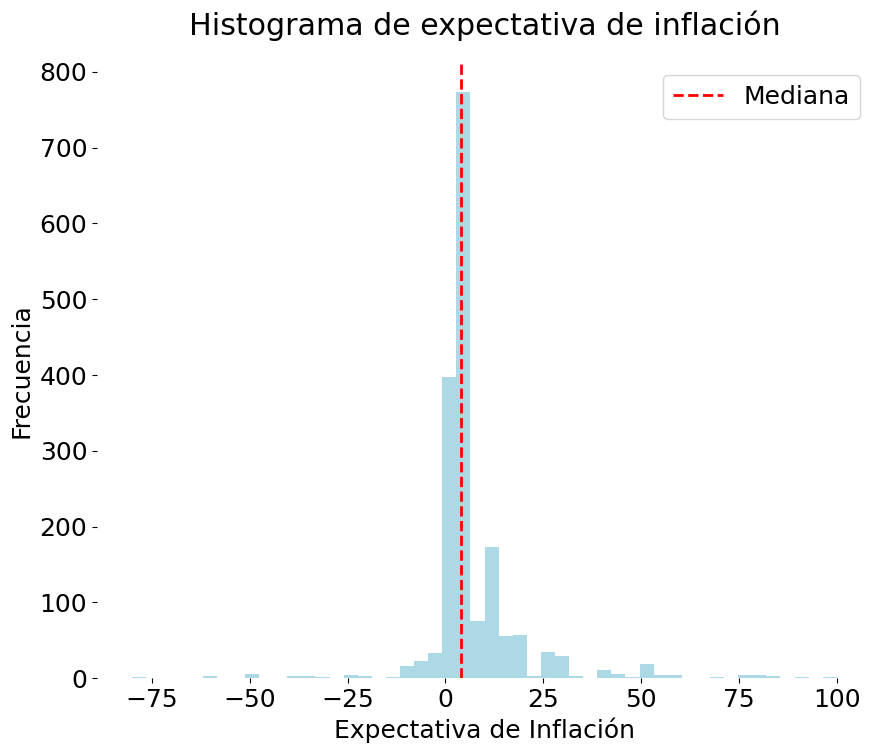

In [ ]:
# ajsute de tamano de plot
plt.rcParams.update({'font.size': 18})

# plot de histograma de la variable dependiente
plt.figure(figsize=(10, 8))
plt.hist(filtered_df['Q8v2part2'], bins=50, edgecolor='none', color='lightblue')
plt.title('Histograma de expectativa de inflación', pad=20)
plt.xlabel('Expectativa de Inflación')
plt.ylabel('Frecuencia')

# adicionamos recta vertical en mediana
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label='Mediana')

plt.legend()
plt.grid(False)
plt.box(False)
plt.show()

A continuación presentamos la distribución de la variable dependiente categórica de la expectativa de la inflación. Se puede notar que es una variable balanceada (ya que se basó en la mediana de la distribución). Dado que se trata de un problema balanceado y no hay un motivo claro para querer minimizar un tipo de error en este contexto, vamos a usar el accuracy como métrica de clasificación. Uno podría pensar que el recall es mejor por detectar bien a los individuos que esperan inflación alta, pero también podría ser un problema la deflación. Para mantener el problema de forma general, vamos a usar el accuracy.

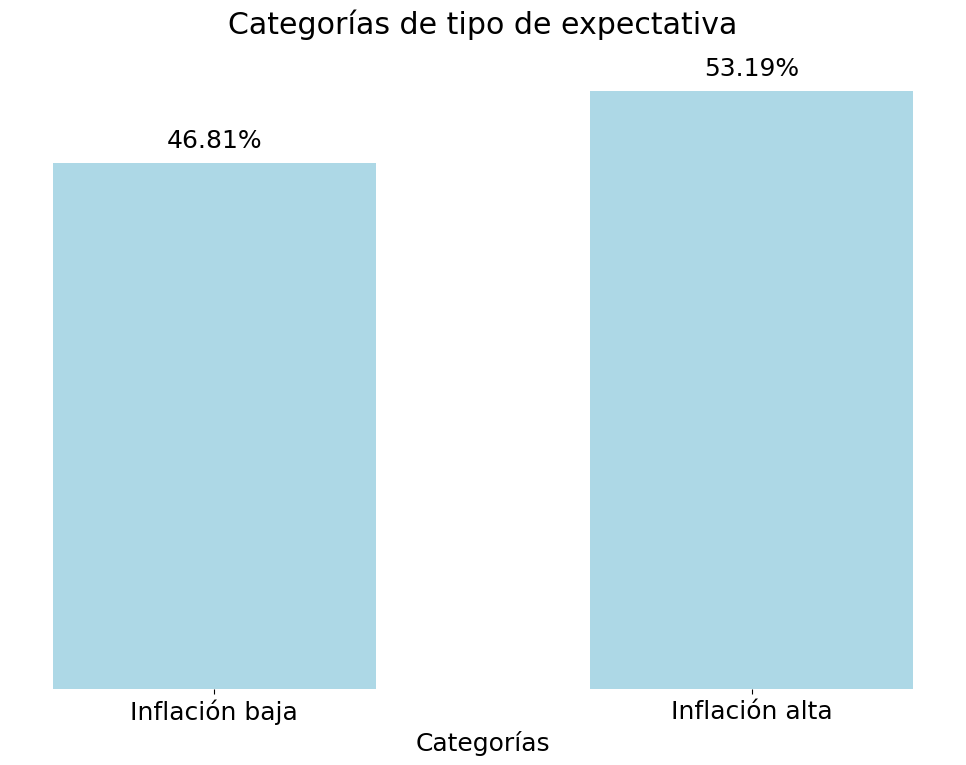

In [ ]:
# ajustamos tamano de plot
plt.figure(figsize=(10, 8))

# plot en barras de variable dependiente categorica
proportions = filtered_df['expec'].value_counts(normalize=True)
bars = plt.bar(proportions.index, proportions.values, color='lightblue', edgecolor='none', width=0.6)  # Changed color to light blue and adjusted bar width

# sacamos cuadro negro y grid
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid(False)
plt.tick_params(axis='y', which='both', left=False)
plt.title('Categorías de tipo de expectativa', pad=20)
plt.xlabel('Categorías')
plt.ylabel('Proporción')
plt.xticks(proportions.index, ['Inflación baja', 'Inflación alta'][::-1])
plt.gca().axes.get_yaxis().set_visible(False)

# adicionamos proporciones arriba de cada plot
for bar, proportion in zip(bars, proportions):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{proportion*100:.2f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

Ahora pasamos a visualizar las características (features). La única característica numérica utilizada es la edad de los individuos. En la imagen siguiente, presentamos el histograma de las edades de los agentes en la muestra. Se puede notar que la mediana de las edades es de 53 años. El cuartil inferior es de 40 años, por lo tanto, tenemos una muestra con pocos jóvenes, aunque la edad mínima es de 17 años.

In [ ]:
filtered_df['Q32'].describe()

count    1763.000000
mean       51.741350
std        14.014952
min        17.000000
25%        40.000000
50%        53.000000
75%        62.000000
max        90.000000
Name: Q32, dtype: float64

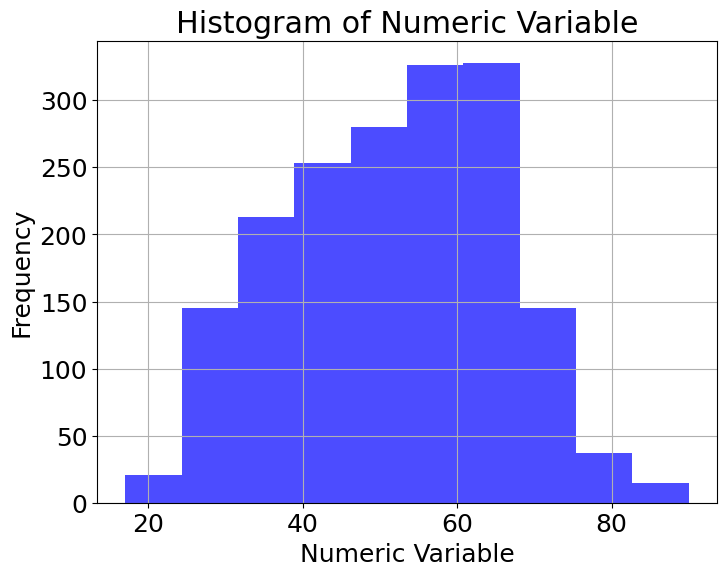

In [ ]:
# histograma de variable edad
plt.figure(figsize=(8, 6))
plt.hist(filtered_df['Q32'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Numeric Variable')
plt.ylabel('Frequency')
plt.title('Histogram of Numeric Variable')
plt.grid(True)
plt.show()

Las otras variables del modelo son categóricas. Para analizar todas las variables de una sola vez, necesitamos agrupar algunas que ya están en formato de variables dummy. Las preguntas 35 y 10 están desglosadas en opciones, a continuación creamos variables sin el encoding.

In [ ]:
# ajsute de pregunta 35
filtered_df.loc[:, 'Q35_partial'] = filtered_df[['Q35_1', 'Q35_2', 'Q35_3', 'Q35_4', 'Q35_5', 'Q35_6']].idxmax(axis=1)
filtered_df.loc[:, 'Q35'] = [int(observation.split('_')[-1]) for observation in filtered_df['Q35_partial']]

# ajsute de pregunta 10
filtered_df.loc[:, 'Q10_partial'] = filtered_df[['Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6', 'Q10_7', 'Q10_8', 'Q10_9', 'Q10_10']].idxmax(axis=1)
filtered_df.loc[:, 'Q10'] = [int(observation.split('_')[-1]) for observation in filtered_df['Q10_partial']]

Finalmente, presentamos las distribuciones de las variables categóricas. La variable Q33, que representa el género de los individuos, está razonablemente balanceada entre género femenino y masculino. Las variables de latino y raza (Q34 y Q35) no muestran un balance tan grande. La variable Q36, de educación, muestra que la mayoría se encuentra en la categoría 5 (que corresponde a Bachelors Degree), pero hay cierto balance entre las categorías. La pregunta 38, sobre estado civil, muestra un sesgo hacia personas casadas y la de estado de empleo (Q10) muestra un sesgo hacia personas trabajando a tiempo completo. Finalmente, la variable 47, que representa el ingreso, muestra una buena distribución entre las categorías.

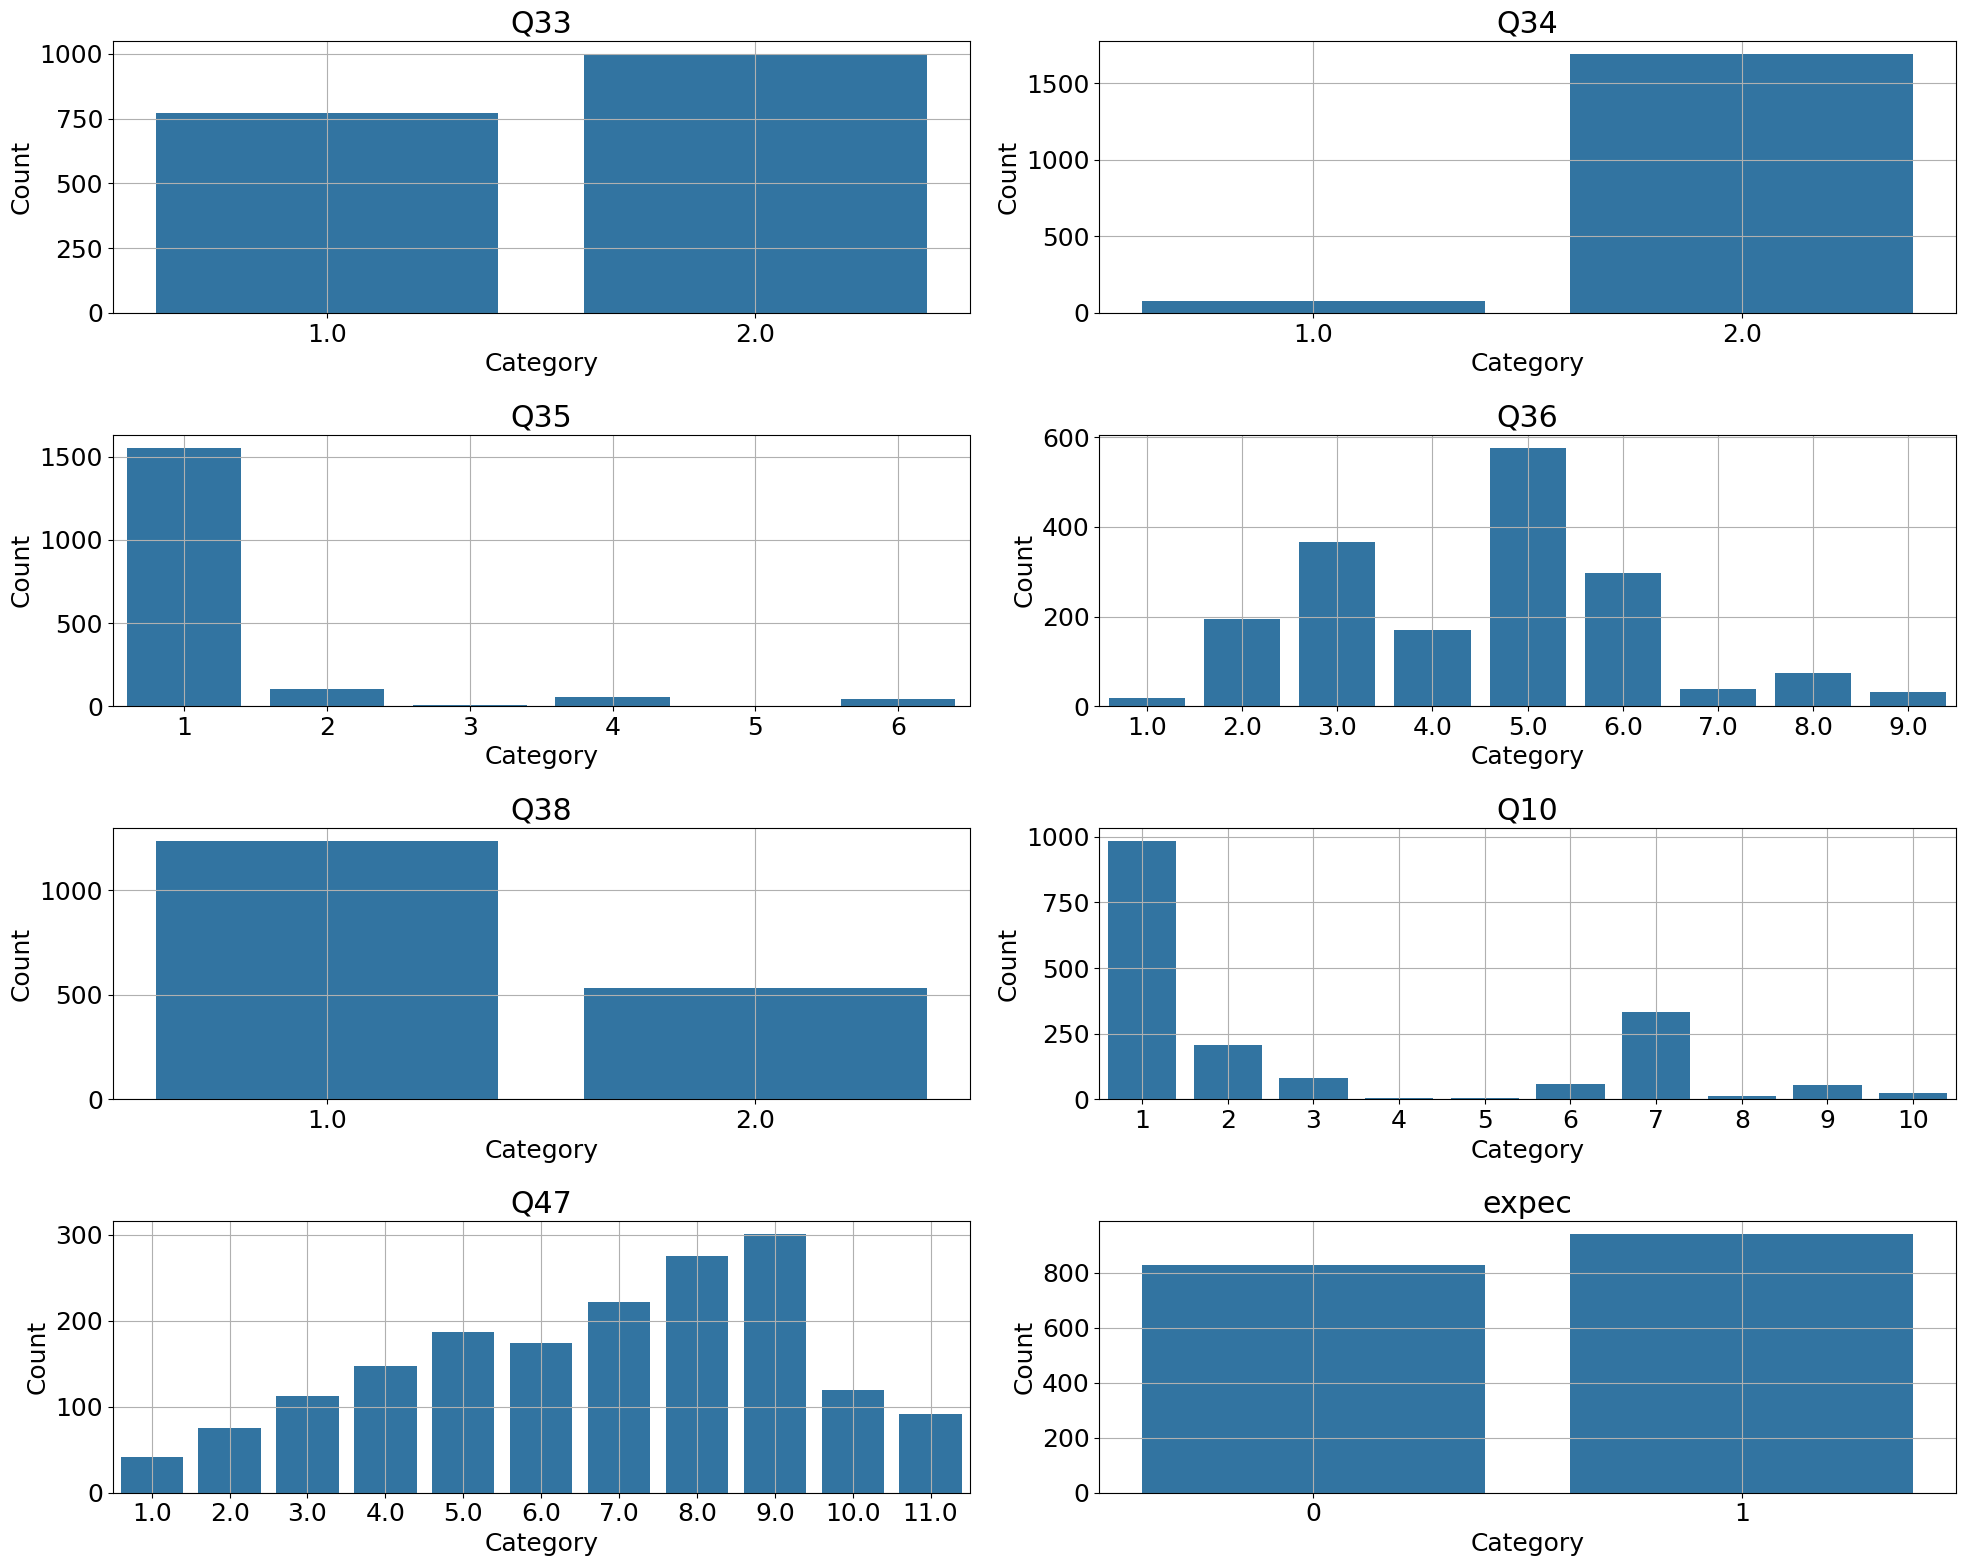

In [ ]:
# creamos vector de columnas categoricas
categorical_columns = ['Q33', 'Q34', 'Q35', 'Q36', 'Q38', 'Q10', 'Q47', 'expec']

# Calculamos el numero de lineas para el plot
num_plots = len(categorical_columns)
num_rows = (num_plots + 1) // 2

# Crear los subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 4))

# Graficar cada histograma
for i, column in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=filtered_df, x=column, ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()

Para la variable de estado de residencia en Estados Unidos, creamos un gráfico aparte (dado que implica un número mucho mayor de categorías). Se puede notar que los estados más representados en la muestra son California, Nueva York y Pensilvania. Sin embargo, hay representación en varios estados.

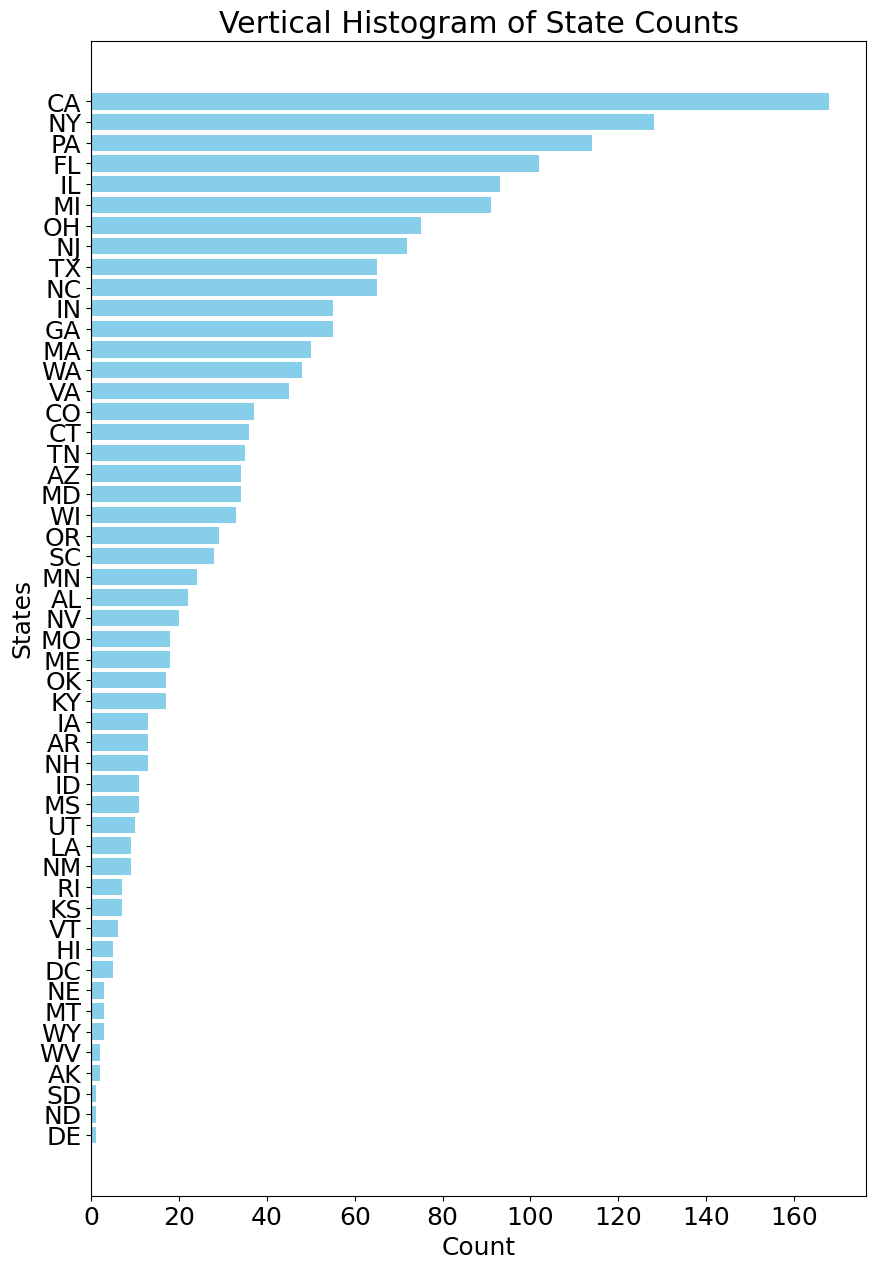

In [ ]:
# creamos vector con conteo de cada estado
state_counts = filtered_df['_STATE'].value_counts().to_dict()

states = list(state_counts.keys())
counts = list(state_counts.values())

# plot de baras horizontales
plt.figure(figsize=(10, 15))
plt.barh(states, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('States')
plt.title('Vertical Histogram of State Counts')
plt.gca().invert_yaxis()
plt.show()

Ahora procedemos a entender cómo se pueden relacionar las características con las variables dependientes propuestas. Comenzamos con la variable dependiente continua.

Para la única variable numérica (edad), hacemos un gráfico de dispersión (scatter plot). No se observa una relación clara entre ambas. La correlación entre las variables es mínima.

In [ ]:
# correlacion entre Q32 y expectativa de inflacion
filtered_df['Q32'].corr(filtered_df['Q8v2part2'])

0.008696371882082818

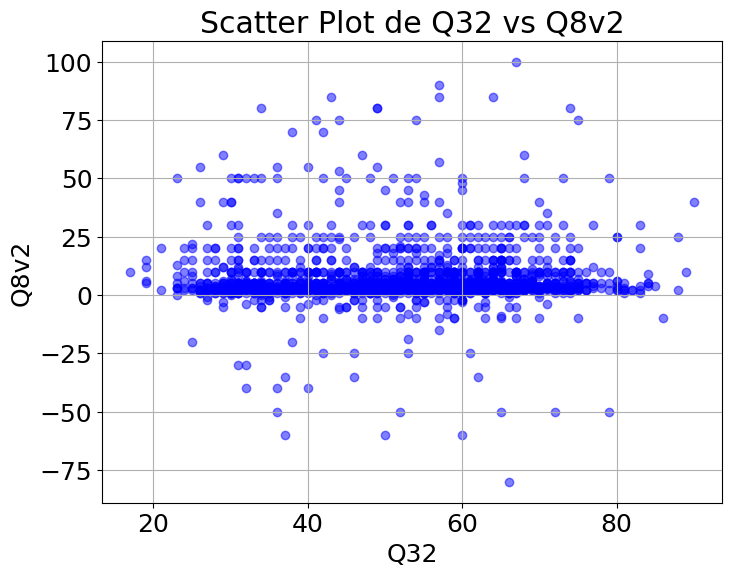

In [ ]:
# Scatter-plot de educacion y expectativa de inflacion
plt.figure(figsize=(8, 6))
plt.scatter(filtered_df['Q32'], filtered_df['Q8v2part2'], alpha=0.5, color='blue')  # Scatter plot of Q32 vs Q8v2
plt.title('Scatter Plot de Q32 vs Q8v2')
plt.xlabel('Q32')
plt.ylabel('Q8v2')
plt.grid(True)
plt.show()

Para las variables categóricas, presentamos el promedio de la expectativa de inflación en cada categoría. En la pregunta sobre género (Q33), parece que las mujeres (categoría 1) tienen en promedio una expectativa de inflación más alta que los hombres. Entre latinos y no latinos y entre los diferentes grupos étnicos, no parece haber diferencias significativas en los promedios. En cuanto al nivel educativo, podemos ver que a medida que aumenta el nivel, las expectativas de inflación tienden a ser menores, lo mismo ocurre con el nivel de ingresos. Respecto al estado de empleo, no parece haber diferencias sistemáticas.

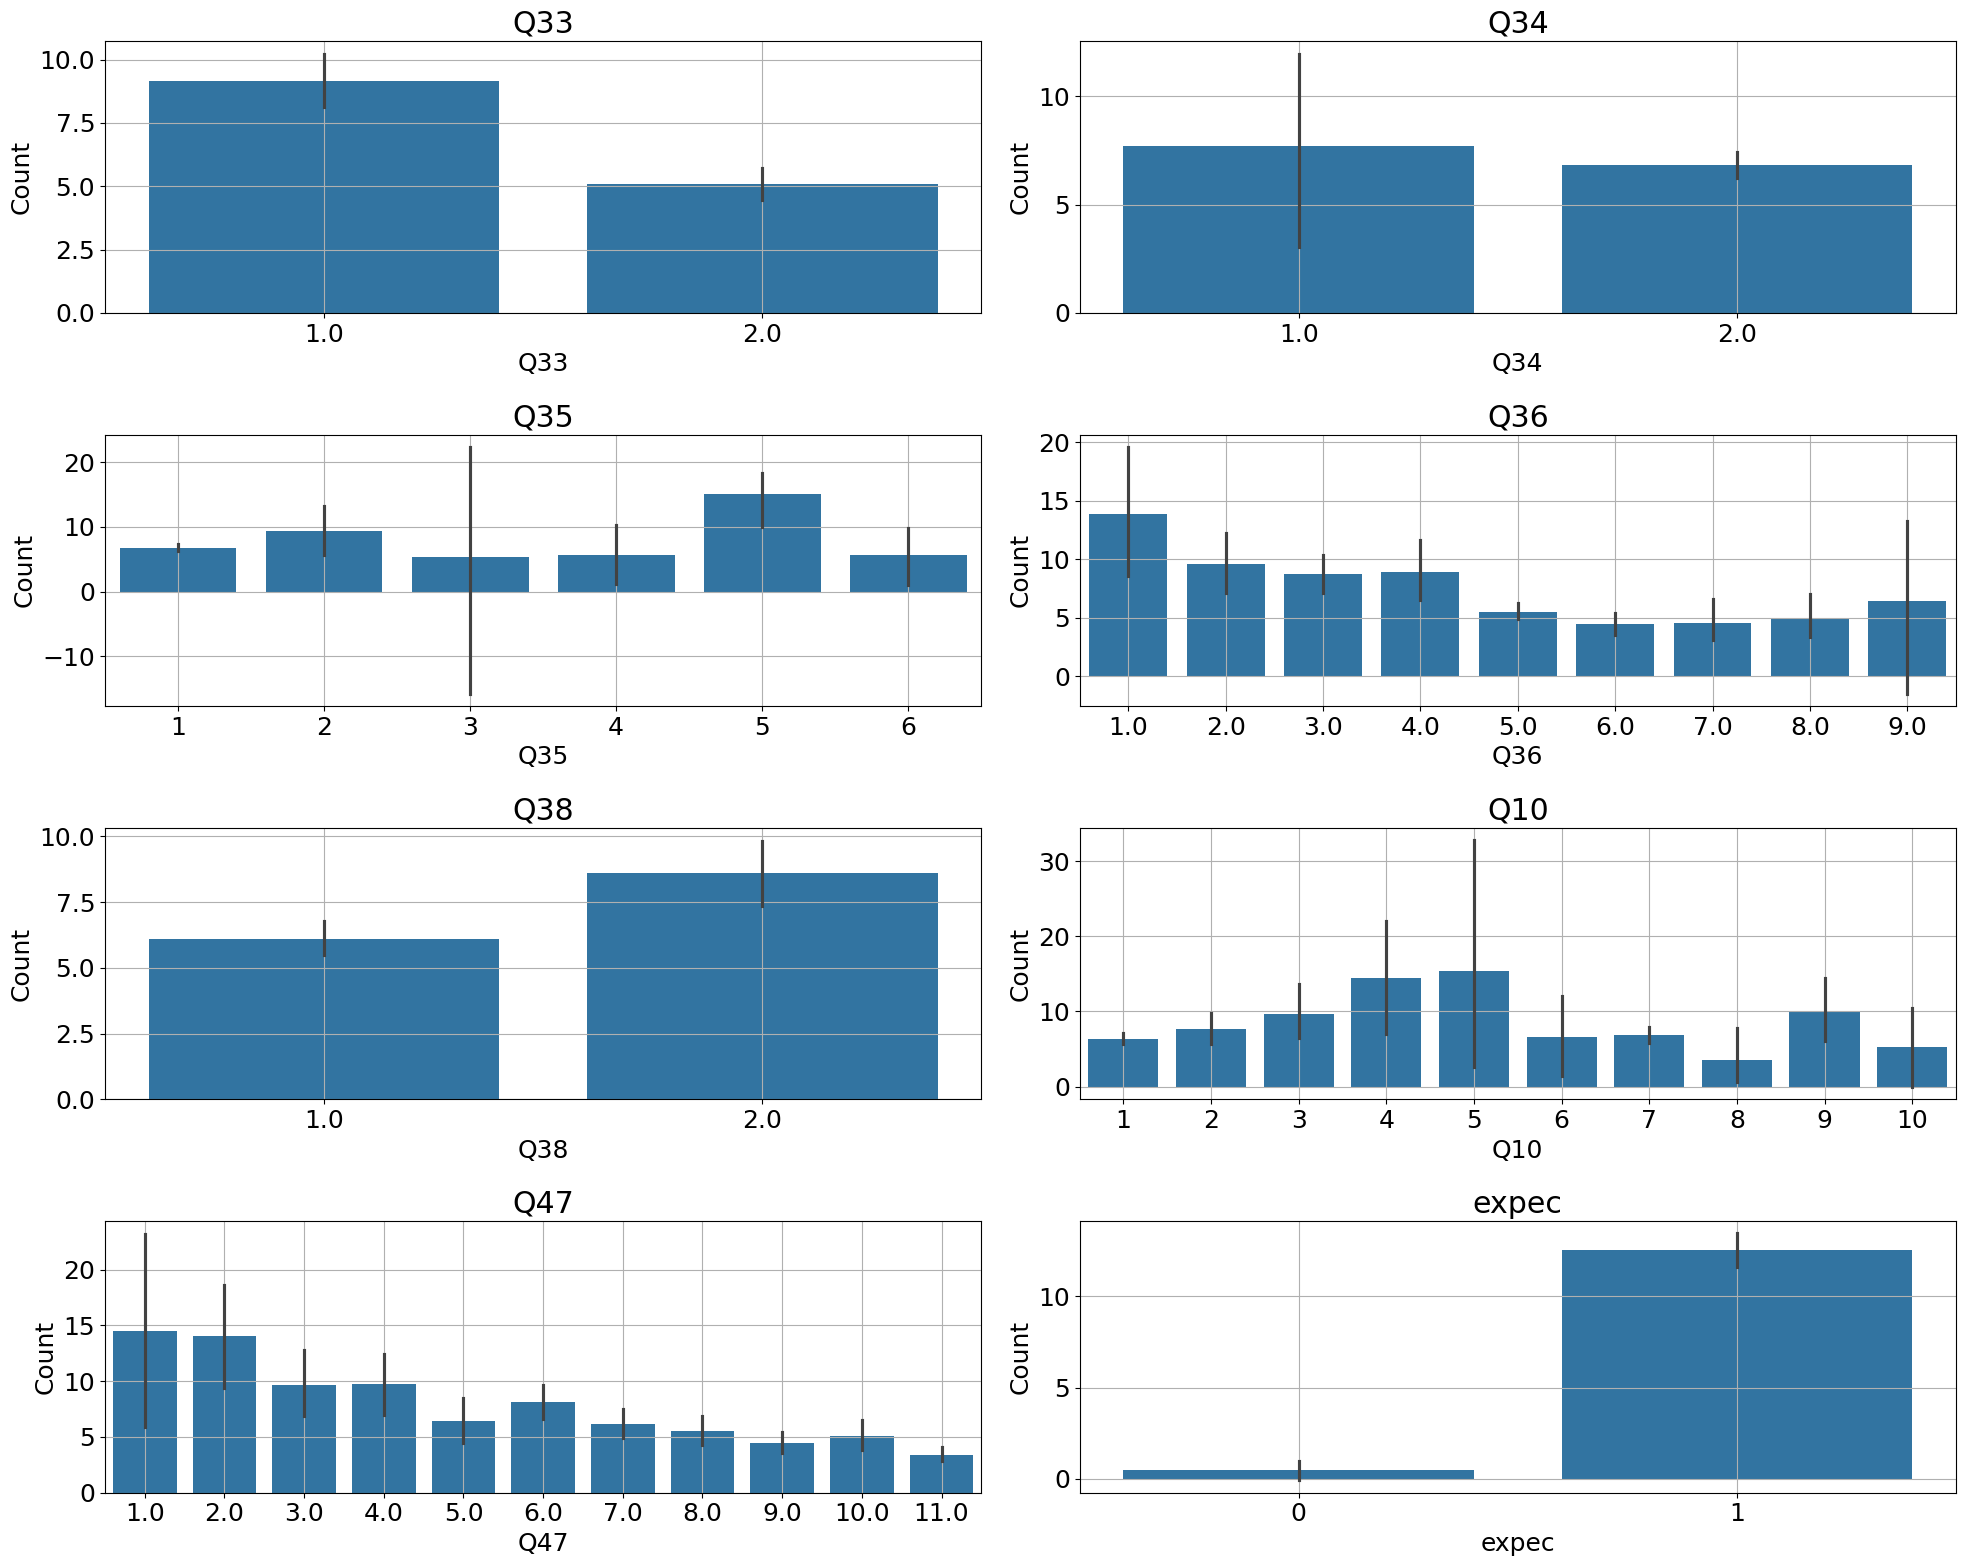

In [ ]:
categorical_columns = ['Q33', 'Q34', 'Q35', 'Q36', 'Q38', 'Q10', 'Q47', 'expec']

# Calculamos el numero de lineas para el plot
num_plots = len(categorical_columns)
num_rows = (num_plots + 1) // 2

# Crear los subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 4))

# Graficar cada histograma
for i, column in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    sns.barplot(x=column, y='Q8v2part2', data=filtered_df, ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()

Con respecto a los diferentes estados, parece haber una variabilidad importante en las expectativas de inflación. Esta conclusión se desprende al observar la figura siguiente.

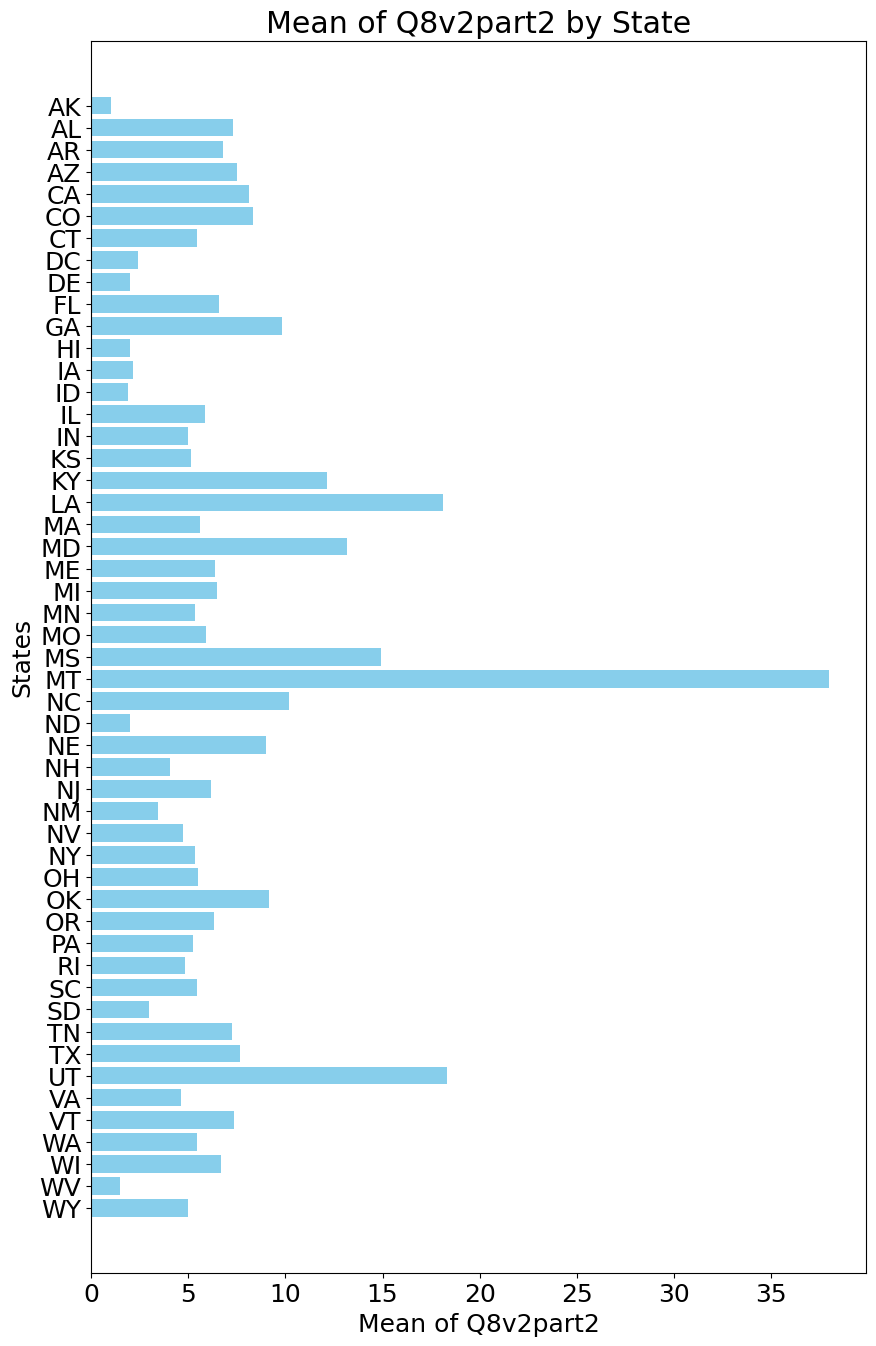

In [ ]:
# promedio de expectativa por estado
state_means = filtered_df.groupby('_STATE')['Q8v2part2'].mean()

states = state_means.index.tolist()
means = state_means.tolist()

# Plotting de baras horizontales
plt.figure(figsize=(10, 16))
plt.barh(states, means, color='skyblue')
plt.xlabel('Mean of Q8v2part2')
plt.ylabel('States')
plt.title('Mean of Q8v2part2 by State')
plt.gca().invert_yaxis()
plt.show()

Ahora realizamos el mismo análisis para la variable categórica de la expectativa de inflación. Con esta variable, es más fácil observar la relación que existe entre la edad y la expectativa. Hay un grupo entre 50 y 70 años que parece esperar una inflación mayor que el grupo entre 20 y 40 años. Esto puede estar relacionado con individuos que vivieron la inflación de los años 1970 en Estados Unidos.

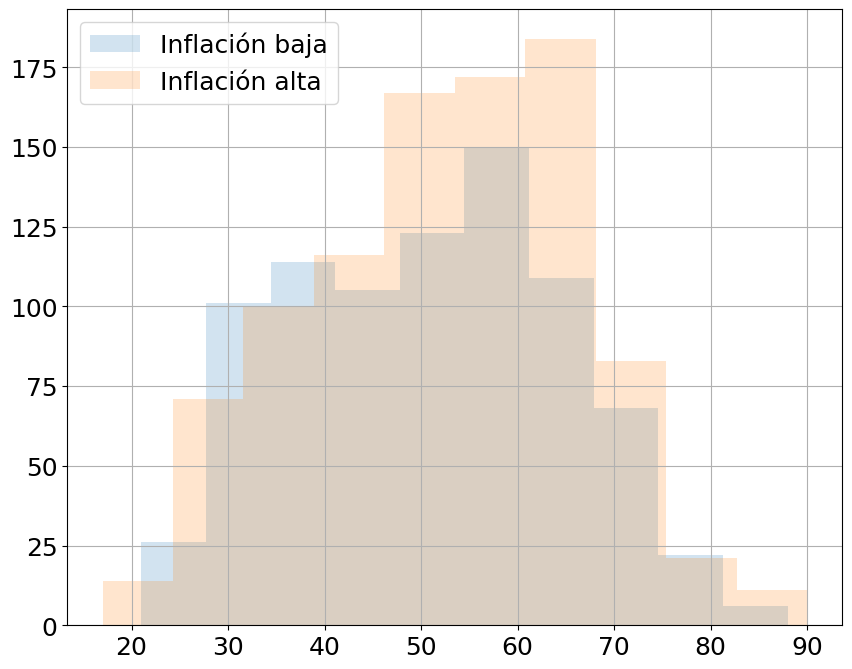

In [ ]:
# histograma de educacion por categoria de expectativa
plt.figure(figsize=(10, 8))
filtered_df.groupby("expec").Q32.hist(alpha=0.2)
plt.legend(['Inflación baja', 'Inflación alta'])
plt.show()

Para las otras variables, el análisis es similar al realizado anteriormente. Observamos algunas diferencias entre géneros, nivel educativo, nivel de ingresos y estado de residencia. En cuanto a las demás variables, las diferencias son menores.

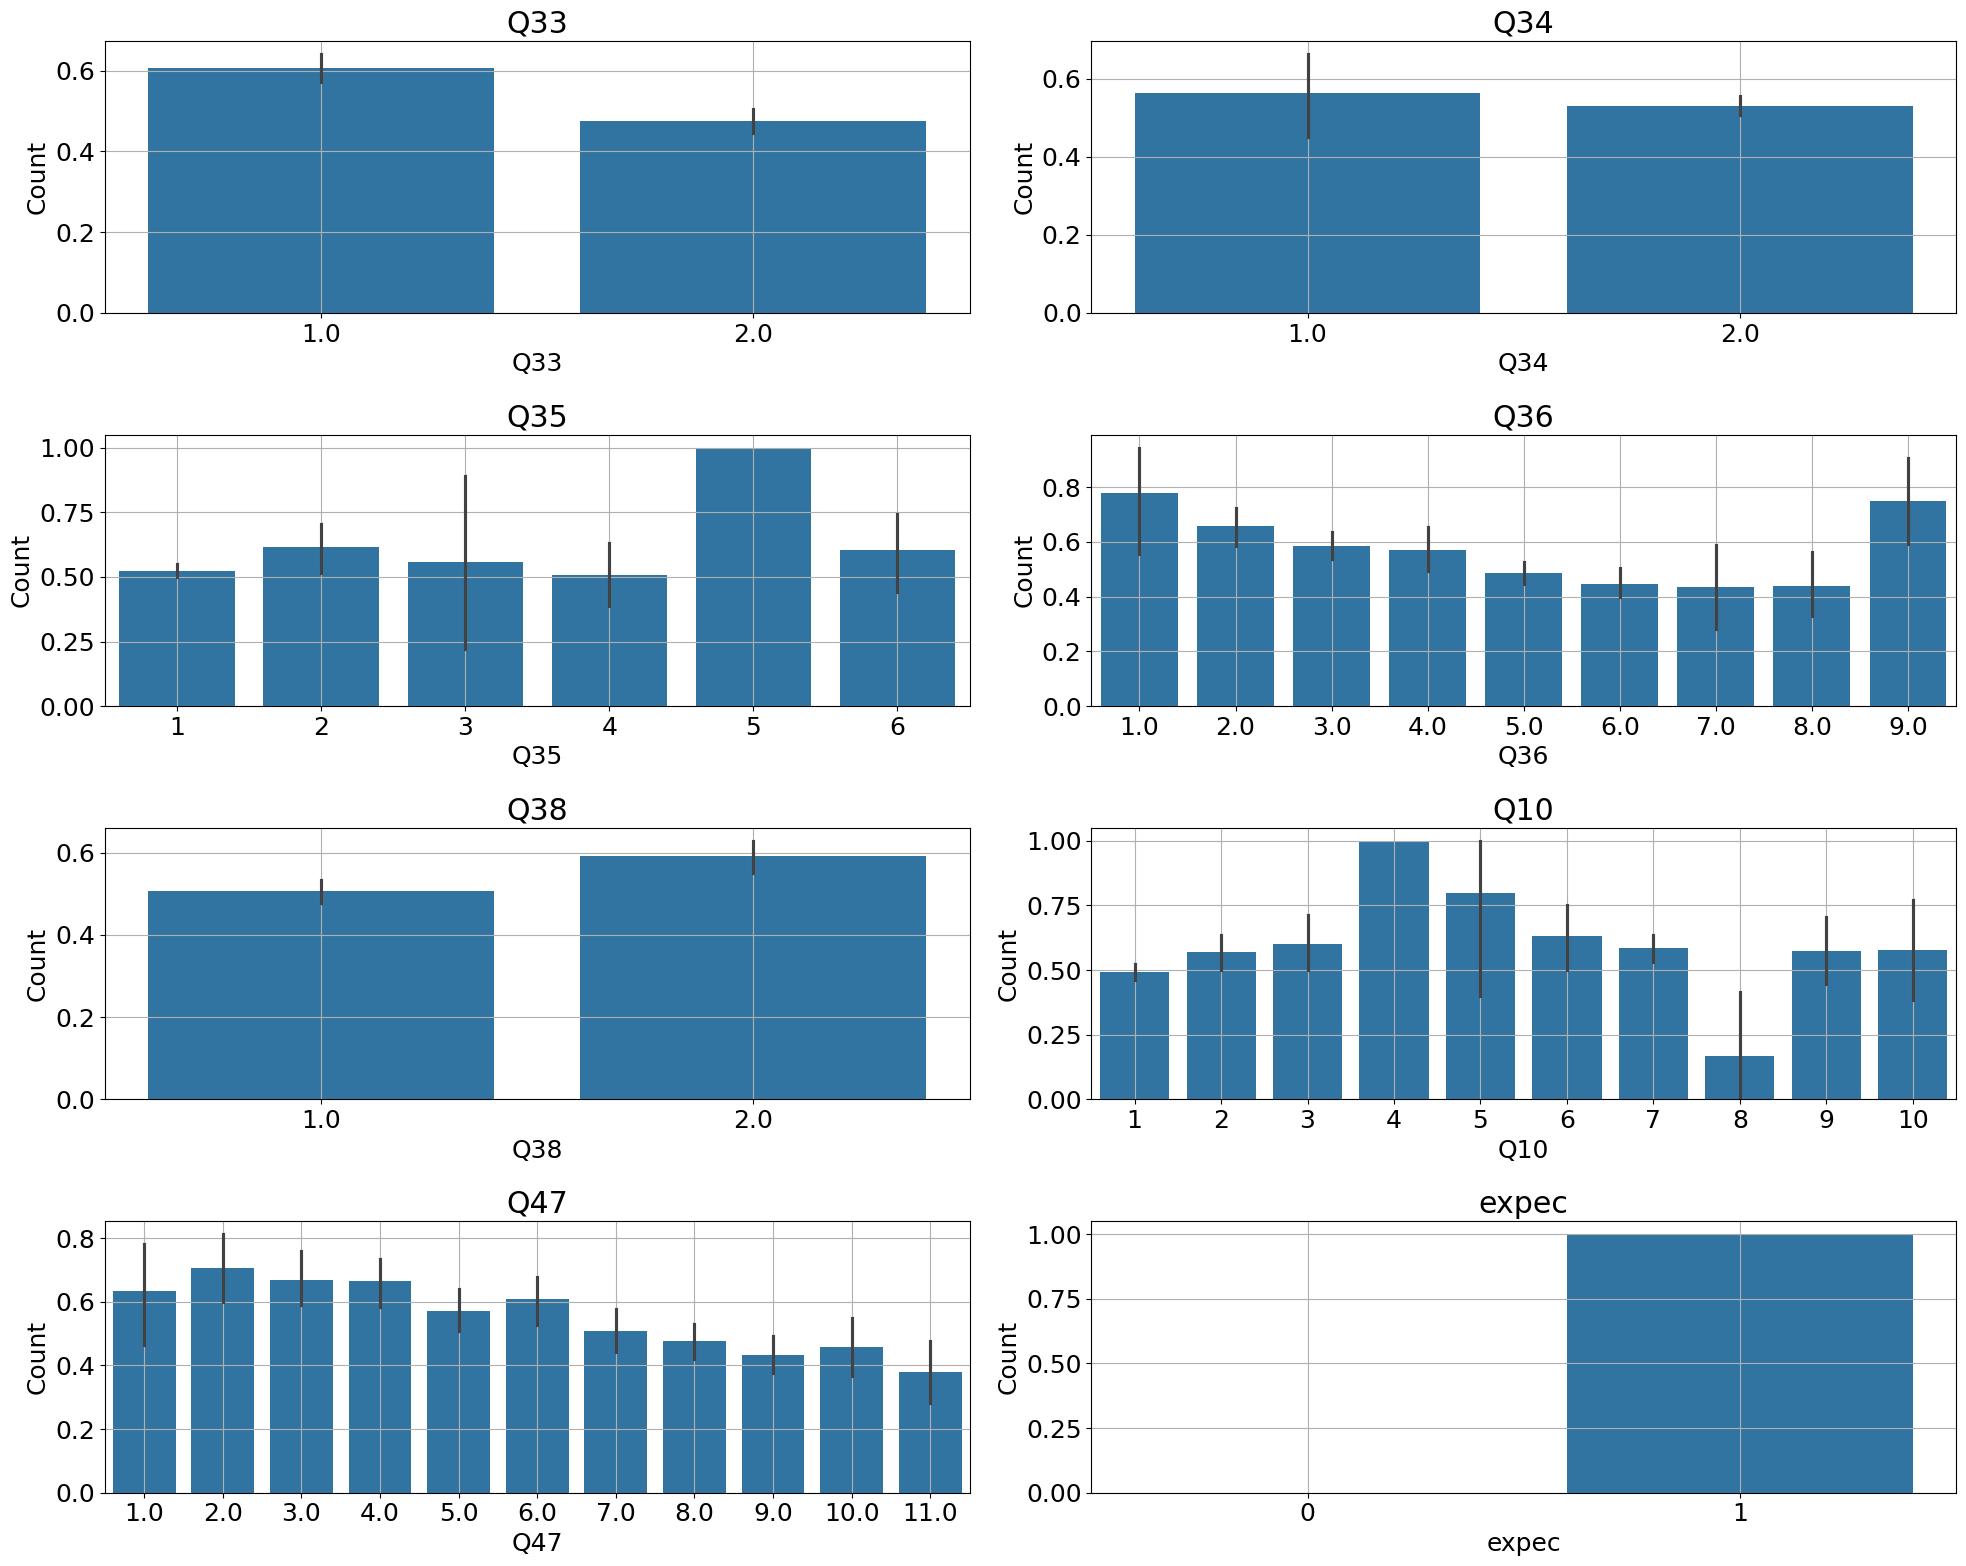

In [ ]:
categorical_columns = ['Q33', 'Q34', 'Q35', 'Q36', 'Q38', 'Q10', 'Q47',  'expec']

# Calculamos el numero de lineas para el plot
num_plots = len(categorical_columns)
num_rows = (num_plots + 1) // 2

# Crear los subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(20, num_rows * 4))

# Graficar cada histograma
for i, column in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    sns.barplot(x=column, y='expec', data=filtered_df, ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.grid(True)

plt.tight_layout()
plt.show()

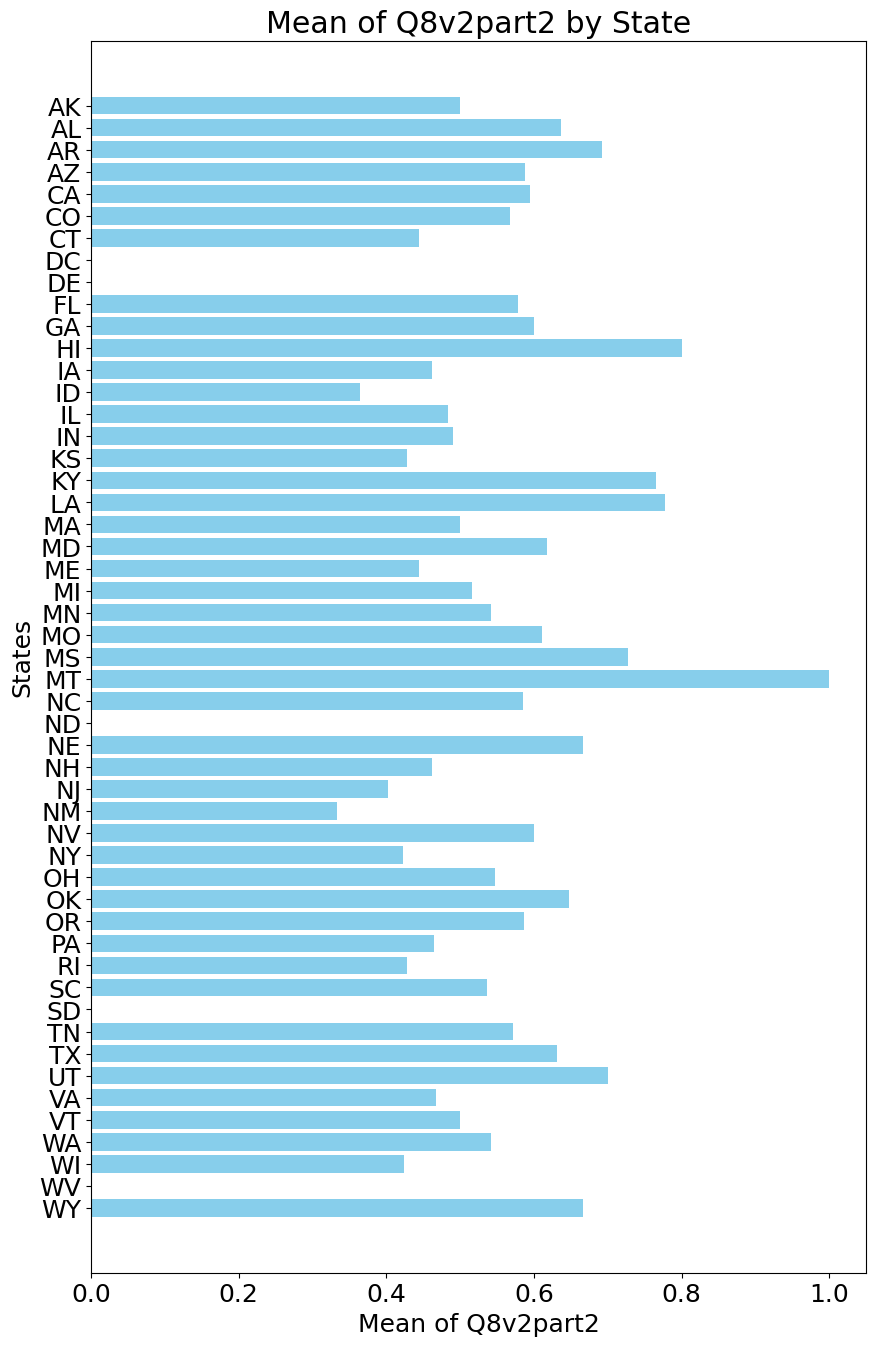

In [ ]:
# calculamos el promedio de cada grupo por cada estado
state_means = filtered_df.groupby('_STATE')['expec'].mean()
states = state_means.index.tolist()
means = state_means.tolist()

# Plotting horizontal
plt.figure(figsize=(10, 16))
plt.barh(states, means, color='skyblue')
plt.xlabel('Mean of Q8v2part2')
plt.ylabel('States')
plt.title('Mean of Q8v2part2 by State')
plt.gca().invert_yaxis()
plt.show()

## 3. Feature Engineering <a name="seccion3"></a>

En esta sección explicamos tres procedimientos de feature engineering. Primero, como habíamos mencionado anteriormente, eliminamos las observaciones que tienen alguna feature relevante faltante de los datos. En agosto de 2013, había un total de 1769 observaciones. Con la eliminación de las observaciones con elementos faltantes, quedan 1730 observaciones (se eliminaron 39 filas).

In [ ]:
# seleccionamos las variables relevantes en una nueva base
selected_df = filtered_df[['Q8v2part2', 'expec', 'Q32', 'Q33', 'Q34', 'Q35_1', 'Q35_2', 'Q35_3', 'Q35_4', 'Q35_5', 'Q35_6', 'Q36', 'Q38', 'Q10_1', 'Q10_2', 'Q10_3', 'Q10_4', 'Q10_5', 'Q10_6', 'Q10_7', 'Q10_8', 'Q10_9', 'Q10_10', '_STATE', 'Q47']]

# eliminamos observaciones con valores faltantes
selected_df = selected_df.dropna()

In [ ]:
# informacion general de la nueva base
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1730 entries, 2450 to 4218
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Q8v2part2  1730 non-null   float64
 1   expec      1730 non-null   int64  
 2   Q32        1730 non-null   float64
 3   Q33        1730 non-null   float64
 4   Q34        1730 non-null   float64
 5   Q35_1      1730 non-null   float64
 6   Q35_2      1730 non-null   float64
 7   Q35_3      1730 non-null   float64
 8   Q35_4      1730 non-null   float64
 9   Q35_5      1730 non-null   float64
 10  Q35_6      1730 non-null   float64
 11  Q36        1730 non-null   float64
 12  Q38        1730 non-null   float64
 13  Q10_1      1730 non-null   int64  
 14  Q10_2      1730 non-null   int64  
 15  Q10_3      1730 non-null   int64  
 16  Q10_4      1730 non-null   int64  
 17  Q10_5      1730 non-null   int64  
 18  Q10_6      1730 non-null   int64  
 19  Q10_7      1730 non-null   int64  
 20  Q10_8     

Después de eliminar las observaciones faltantes, utilizamos el comando get_dummies para convertir las features categóricas que no están en formato de dummy. Las variables Q33, Q34, Q35, Q38 y Q10 son categóricas pero ya están en el formato deseado, por lo que solo necesitamos ajustar las variables Q36, _STATE y Q47. Aprovechamos este paso para crear los objetos de las variables dependientes Y_reg y Y_clag, así como las features X_encoded.

In [ ]:
# creamos las variables dependientes
Y_reg = selected_df['Q8v2part2']
Y_cla = selected_df['expec']

# creamos las features
X = selected_df.drop(columns=['Q8v2part2', 'expec'])

# ajustamos las features categoricas faltantes
X_encoded = pd.get_dummies(X, columns=['Q36', '_STATE', 'Q47'])

La última transformación necesaria es escalar las features. Algunos algoritmos, como el Multilayer Perceptron (MLP), requieren que las variables estén escaladas para obtener un mejor rendimiento. Dado que planeamos usar este método, aplicamos el escalado para evitar sesgos entre los algoritmos. Es crucial realizar el escalado después de dividir los datos en conjunto de entrenamiento y prueba. Si no se hace esta división primero, existe el riesgo de data leakage. Por lo tanto, primero separamos el 80% de los datos para entrenamiento y el 20% para prueba, utilizando una semilla (seed) de 12345 para garantizar la reproducibilidad en los modelos de regresión y clasificación.

In [ ]:
reg = {}

# separacion de datos en datos de entreno y datos de testeo para regresion
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y_reg, test_size=0.2, random_state=12345)
reg = {
    "X_train": X_train,
    "X_test": X_test,
    "Y_train": Y_train,
    "Y_test":Y_test
}

# separacion de datos en datos de entreno y datos de testeo para clasificacion
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y_cla, test_size=0.2, random_state=12345)
cla = {
    "X_train": X_train,
    "X_test": X_test,
    "Y_train": Y_train,
    "Y_test":Y_test
}

Finalmente, aplicamos el método scaler.transform para escalar las features en todos los datos.

In [ ]:
# ajustamos la escala de los datos de entreno
scaler = StandardScaler()
scaler.fit(reg["X_train"])
reg["X_train"] = scaler.transform(reg["X_train"])
reg["X_test"] = scaler.transform(reg["X_test"])

# ajustamos la escala de los datos de testeo
scaler = StandardScaler()
scaler.fit(cla["X_train"])
cla["X_train"] = scaler.transform(cla["X_train"])
cla["X_test"] = scaler.transform(cla["X_test"])

## 4. Entrenamiento <a name="seccion4"></a>

Para optimizar el código, creamos una función de entrenamiento de modelos a continuación. Con esta función, podemos entrenar tanto modelos de regresión como de clasificación usando tres métodos seleccionados: Random Forest, XGBoost y Multilayer Perceptron (MLP). Además, medimos y guardamos el tiempo de computación del entrenamiento a través de GridSearch.

In [ ]:
def tune_model(model, params, scoring, X_train, Y_train):
    start_time = time.time()  # guarda el tiempo de computo

    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # grid search por los parametros
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=scoring)
    grid_search.fit(X_train, Y_train)

    end_time = time.time()
    elapsed_time = end_time - start_time  # calcula tiempo de computo

    # escoge mejor modelo
    best_model = grid_search.best_estimator_

    return best_model, elapsed_time

En el código siguiente, definimos los parámetros usados en cada modelo. Elegimos cinco combinaciones de parámetros por algoritmo para mantener una comparación equilibrada, basándonos en prácticas comunes en la literatura.

In [ ]:
# definimos los parametros para cada algoritmo

# algoritmo neural networks
nn_params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['identity', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# algoritmo random forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

# algoritmo xgboost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

En el siguiente código, entrenamos los modelos de regresión. La métrica utilizada es el MAE (Error Absoluto Medio). Como mencionamos anteriormente, elegimos esta métrica porque no penaliza tanto los errores grandes, lo cual es adecuado dado que nuestras variables dependientes tienen alta varianza y no consideramos necesario eliminar los outliers.

Esta parte del código suele tomar tiempo para ejecutarse. Normalmente, el modelo MLP puede tardar unos 9 minutos, el modelo de Random Forest unos 8 minutos y el modelo XGBoost unos 4 minutos.

In [ ]:
# entrenamos el mejor modelo de neural networks para regresion
best_nn_model_reg, nn_reg_time = tune_model(MLPRegressor(random_state=1234), nn_params, 'neg_mean_absolute_error', reg["X_train"], reg["Y_train"])

# entrenamos el mejor modelo de random forest para regresion
best_rf_model_reg, rf_reg_time = tune_model(RandomForestRegressor(random_state=1234), rf_params, 'neg_mean_absolute_error', reg["X_train"], reg["Y_train"])

# entrenamos el mejor modelo de xgboost para regresion
best_xgb_model_reg, xgb_reg_time = tune_model(XGBRegressor(random_state=1234), xgb_params, 'neg_mean_absolute_error', reg["X_train"], reg["Y_train"])

Luego, entrenamos los modelos de clasificación en el código siguiente. Optamos por optimizar la métrica de exactitud (accuracy) dado que no tenemos un motivo específico para preferir un tipo de error sobre otro, considerando que los datos están balanceados entre las categorías.

Nuevamente, esta parte del código puede demorar en ejecutarse. Usualmente, el modelo MLP toma alrededor de 7 minutos, el modelo de Random Forest toma unos 8 minutos y el modelo XGBoost toma unos 4 minutos.

In [ ]:
# entrenamos el mejor modelo de neural networks para clasificacion
best_nn_model_cla, nn_cla_time = tune_model(MLPClassifier(max_iter=200, random_state=1234), nn_params, 'accuracy', cla["X_train"], cla["Y_train"])

# entrenamos el mejor modelo de random forest para clasificacion
best_rf_model_cla, rf_cla_time = tune_model(RandomForestClassifier(random_state=1234), rf_params, 'accuracy', cla["X_train"], cla["Y_train"])

# entrenamos el mejor modelo de xgboost para clasificacion
best_xgb_model_cla, xgb_cla_time = tune_model(XGBClassifier(random_state=1234), xgb_params, 'accuracy', cla["X_train"], cla["Y_train"])

## 5. Evaluación <a name="seccion5"></a>

Para evaluar los modelos de regresión, creamos una función que devuelve las dos métricas relevantes de análisis. Al crear una función, aumentamos la eficiencia del código. Las dos métricas de interés con las que evaluamos los modelos son el MAE y el RMSE (aunque también consideramos el tiempo de computación, ya obtenido en la función anterior).

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # prediccion en base de testeo
    y_pred = model.predict(X_test)

    # Calcula metricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    return rmse, mae

Con esta función, podemos calcular rápidamente las métricas y determinar el modelo con mejor rendimiento. Como se mencionó, la métrica principal elegida fue el MAE, que no penaliza tanto los errores grandes debido a que no transformamos la variable dependiente. Sin embargo, también calculamos el RMSE por completitud. Observamos que en general, los modelos basados en árboles tienen mejores métricas que el modelo de redes neuronales. Además, el tiempo de computación del Multilayer Perceptron (MLP) es considerablemente mayor que el de los otros modelos. Entre el modelo de Random Forest y XGBoost, el primero tiene ligeramente mejores métricas de MAE y RMSE, aunque XGBoost es significativamente más rápido que Random Forest. En general, los errores son considerablemente grandes en comparación con el promedio de la variable dependiente, pero hay que recordar dos factores importantes. Primero, estamos estimando la expectativa de inflación a nivel individual, lo cual aumenta la varianza entre las observaciones. Segundo, el proyecto se centra no solo en seleccionar el mejor predictor, sino también en comprender cómo se construyó esa decisión. Para esto, realizaremos un cálculo de la importancia de las características en la siguiente sección.

In [ ]:
# metricas de neural networks
nn_rmse, nn_mae = evaluate_model(best_nn_model_reg, reg["X_train"], reg["Y_train"], reg["X_test"], reg["Y_test"])
print(f"Neural Network RMSE: {nn_rmse:.4f}")
print(f"Neural Network MAE: {nn_mae:.4f}")
print(nn_reg_time/60)

# metricas de random forest
rf_rmse, rf_mae = evaluate_model(best_rf_model_reg, reg["X_train"], reg["Y_train"], reg["X_test"], reg["Y_test"])
print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest MAE: {rf_mae:.4f}")
print(rf_reg_time/60)

# metricas de xgboost
xgb_rmse, xgb_mae = evaluate_model(best_xgb_model_reg, reg["X_train"], reg["Y_train"], reg["X_test"], reg["Y_test"])
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(xgb_reg_time/60)

Neural Network RMSE: 14.4998
Neural Network MAE: 7.7242
6.622841652234396
Random Forest RMSE: 14.2036
Random Forest MAE: 7.3124
7.9356975078582765
XGBoost RMSE: 14.3836
XGBoost MAE: 7.3420
3.877872029940287


Ahora procedemos de manera similar para los modelos de clasificación. Aquí se consideran varias métricas de interés: accuracy, recall, precision y también creamos la matriz de confusión del modelo.

In [ ]:
def evaluate_and_plot(model, X_test, y_test, title='Confusion Matrix', font_size=14, annot_font_size=12):
    # prediccion en base de testeo
    y_pred = model.predict(X_test)

    # calcula metricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # presenta metricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # grafica matrizes de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
                annot_kws={"size": annot_font_size})
    plt.xlabel('Predicted', fontsize=font_size)
    plt.ylabel('Actual', fontsize=font_size)
    plt.title(title, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.show()

Accuracy: 0.6012
Precision: 0.6276
Recall: 0.6543


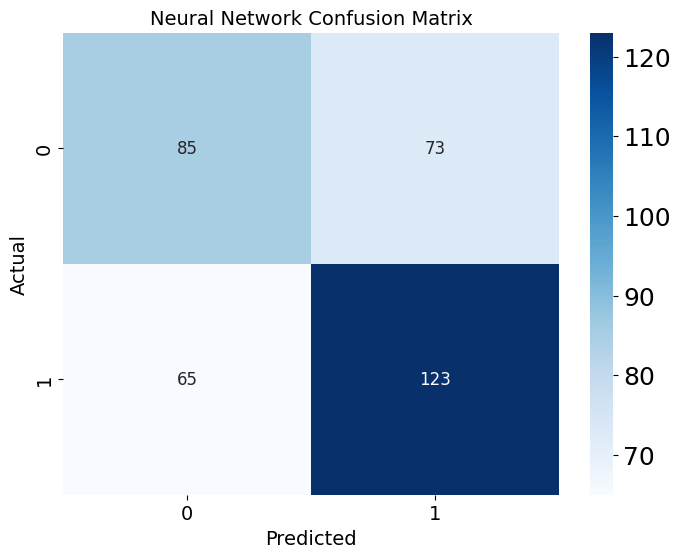

7.965813513596853
Accuracy: 0.6156
Precision: 0.6190
Recall: 0.7606


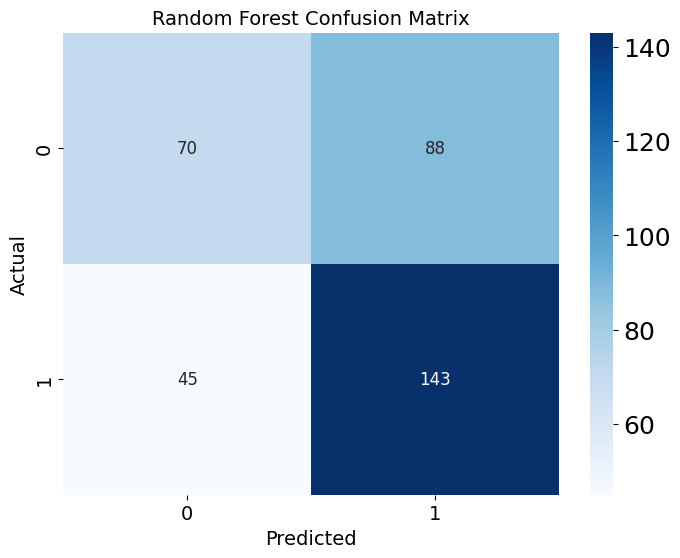

9.237956170241038
Accuracy: 0.6069
Precision: 0.6193
Recall: 0.7181


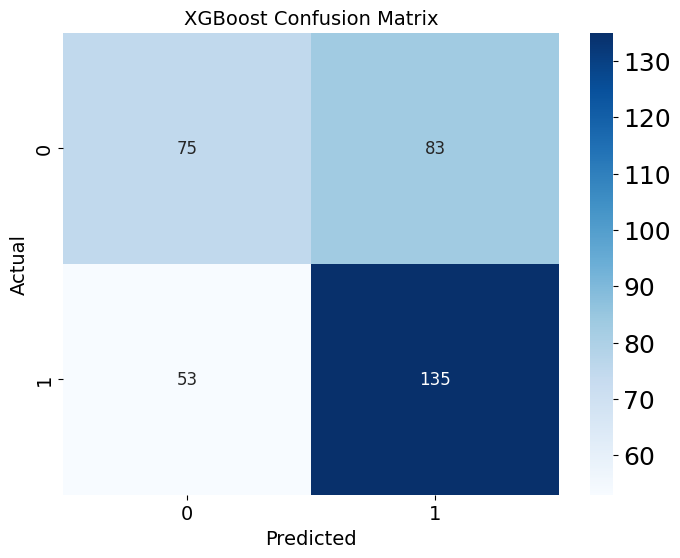

3.551426879564921


In [ ]:
# metricas de neural networks
evaluate_and_plot(best_nn_model_cla, cla["X_test"], cla["Y_test"], title = "Neural Network Confusion Matrix")
print(nn_cla_time/60)

# metricas de random forest
evaluate_and_plot(best_rf_model_cla, cla["X_test"], cla["Y_test"], title = "Random Forest Confusion Matrix")
print(rf_cla_time/60)

# metricas de xgboost
evaluate_and_plot(best_xgb_model_cla, cla["X_test"], cla["Y_test"], title = "XGBoost Confusion Matrix")
print(xgb_cla_time/60)

Nuevamente, observamos que los modelos basados en árboles superan al modelo de redes neuronales en todas las métricas. Entre XGBoost y Random Forest, el segundo supera ligeramente al primero en las métricas de accuracy y recall, a pesar de que XGBoost es considerablemente más rápido que Random Forest. Como se mencionó en la sección de metodología, no tenemos preferencia a priori por maximizar la precisión o el recall en este proyecto (un banco central podría estar interesado en estimar correctamente tanto los casos de deflación como de alta inflación), por lo que nos centramos en el accuracy como métrica principal.

Otra forma de comparar los modelos de clasificación es mediante la curva ROC. En el código a continuación, creamos esta curva para los tres modelos. No hay un claro ganador entre los modelos según la curva ROC, como se refleja también en el cálculo del AUC.

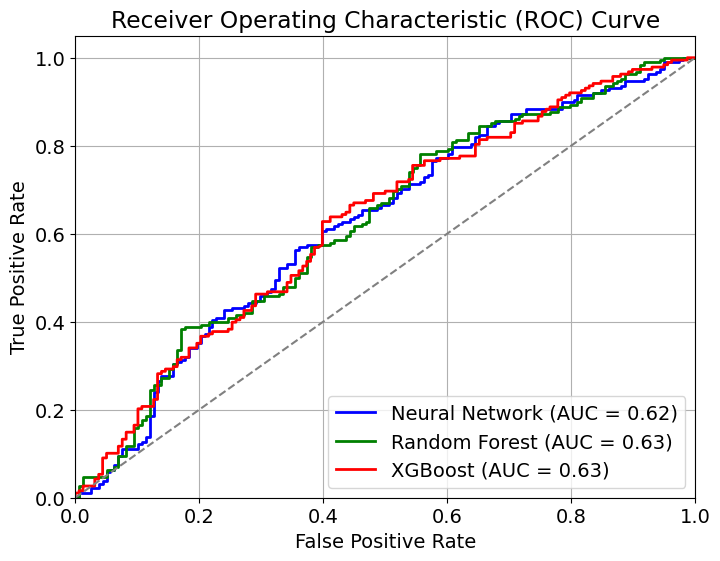

In [ ]:
# cambia la fuente del grafico
plt.rcParams.update({'font.size': 14})

# computa ROC y AUC para cada modelo
models = {
    'Neural Network': (best_nn_model_cla, 'blue'),
    'Random Forest': (best_rf_model_cla, 'green'),
    'XGBoost': (best_xgb_model_cla, 'red')
}

# grafica la curva

plt.figure(figsize=(8, 6))

for model_name, (model, color) in models.items():
    predictions = model.predict_proba(cla['X_test'])[:, 1]
    fpr, tpr, _ = roc_curve(cla['Y_test'], predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

La pregunta central de esta investigación es entender cuáles son los principales atributos que explican la expectativa de inflación de los agentes. Para esto, realizamos un análisis de la importancia de las características, calculando la importancia de cada feature en los modelos seleccionados.

Dado que el modelo de Random Forest mostró los mejores resultados, seleccionamos esta especificación para calcular el indicador de importancia de las características. Esto se hace utilizando el comando model.feature_importances_ de scikit-learn. Este método calcula el promedio de la reducción de la impureza (por ejemplo, la impureza de Gini) en cada árbol del conjunto, asignándole a cada característica un puntaje de importancia a lo largo de todos los árboles.

A continuación, creamos dos funciones, una auxiliar y otra principal, para calcular la importancia de las características de cada modelo y presentar los resultados en un gráfico. Este cálculo es un poco más complejo porque debemos consolidar la importancia de todas las dummies de cada categoría en un solo valor. Para esto, agrupamos todas las dummies por su prefijo y sumamos los valores.

In [ ]:
# funcion que extrae los prefijos
def extract_prefix(variable):
    for prefix in prefixes:
        if variable.startswith(prefix):
            return prefix
    return None

def feature_importances(model, prefixes, prefix_legend_mapping, title):
    # extrae importancia de features
    feature_importances = model.feature_importances_

    # crea la dataframe
    features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    features_df['Prefix'] = features_df.iloc[:, 0].apply(extract_prefix)

    # agrupa por prefijo y los suma
    grouped_df = features_df.groupby('Prefix').sum().reset_index()

    # ordena por importancia en formato decresciente
    grouped_df_sorted = grouped_df.sort_values(by='Importance', ascending=True)
    values = grouped_df_sorted['Importance']

    # mapea los prefijos del grupo
    legend_labels = [prefix_legend_mapping[prefix] for prefix in grouped_df_sorted['Prefix']]

    # hace un plot horizontal
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(10, 8))
    bars = plt.barh(legend_labels, values, color='skyblue')

    for index, value in enumerate(values):
      plt.text(value, index, f' {value*100:.2f}%', ha='left', va='center', fontsize=14)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlabel('Relevancia')
    plt.title(title)
    plt.tight_layout()
    plt.show()

La función toma como argumentos los prefijos que debe buscar y un mapeo entre los prefijos (las preguntas) y su significado real.

In [ ]:
# creacion de prefijos
prefixes = ['Q32', 'Q33', 'Q34', 'Q35', 'Q36', 'Q38', 'Q10', '_STATE', 'Q47']

# mapeo de prefijos y legends
prefix_legend_mapping = {
    'Q32': 'age',
    'Q33': 'gender',
    'Q34': 'latino',
    'Q35': 'race',
    'Q36': 'education',
    'Q38': 'marital status',
    'Q10': 'employment situation',
    '_STATE': 'US state',
    'Q47': 'income'
}

Finalmente, presentamos los resultados de la importancia de las características tanto para el modelo de regresión como para el de clasificación. Se concluye que las variables socioeconómicas, como ingresos, educación y localización, tienen una importancia significativamente mayor que las variables demográficas como latino, grupo étnico y género. Este resultado se alinea con la creciente literatura sobre desigualdad en inflación, que sugiere que los agentes perciben la inflación de manera diferente según su nivel socioeconómico. La percepción de la inflación puede ser más alta si los bienes cuyos precios suben representan una proporción mayor del ingreso del agente. Además, la inflación puede sentirse de manera diferente a nivel regional, lo que explica por qué el estado de residencia es una variable tan relevante en ambas estimaciones. Estos resultados ayudan a fortalecer la evidencia de que la desigualdad de ingresos y las heterogeneidades regionales están impactando la formación de expectativas inflacionarias de los agentes.

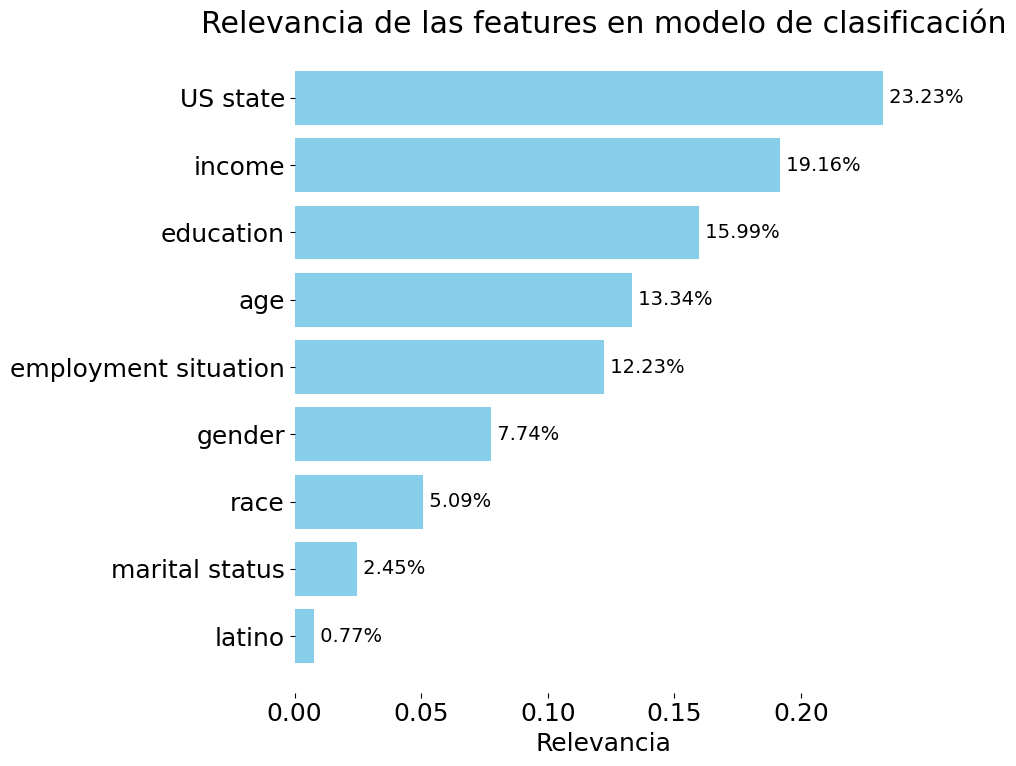

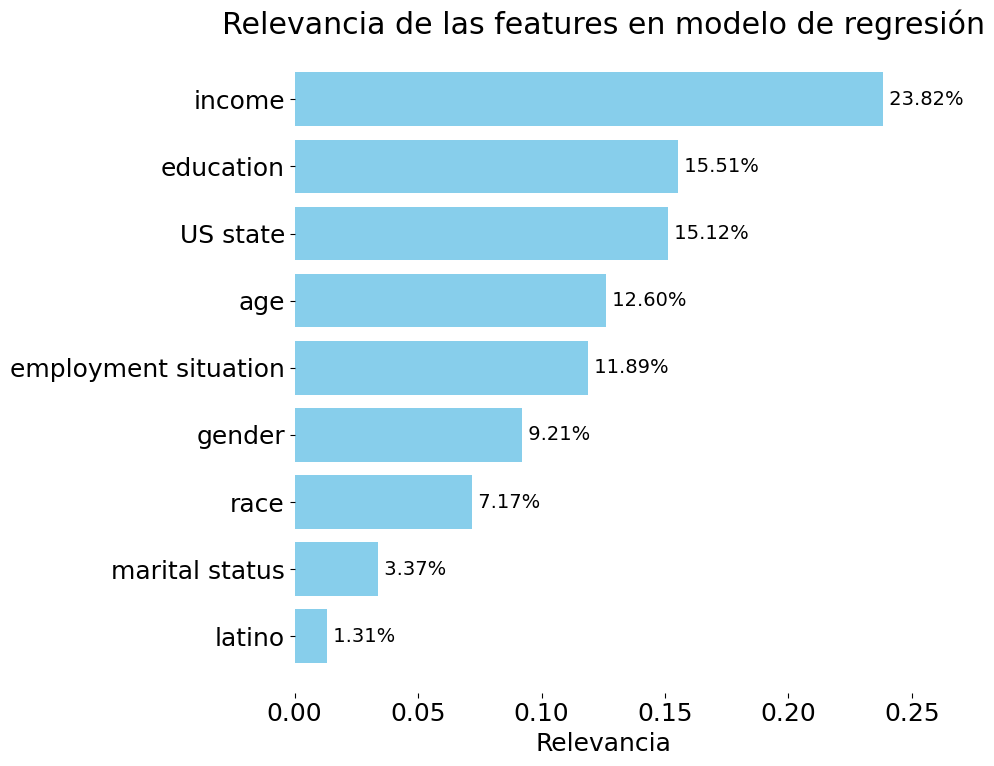

In [ ]:
# calculo de feature importance para modelo de clasificaicon
feature_importances(best_rf_model_cla, prefixes, prefix_legend_mapping, 'Relevancia de las features en modelo de clasificación')

# calculo de feature importance para modelo de regresion
feature_importances(best_rf_model_reg, prefixes, prefix_legend_mapping, 'Relevancia de las features en modelo de regresión')